In [1]:
import sys

import astropy.units as u
from astropy.coordinates import SkyCoord
import astropy.wcs
from astropy.visualization import ImageNormalize, LogStretch, quantity_support
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.io import readsav
import sunpy.map
import ndcube
import distributed

from synthesizAR.instruments import InstrumentDEM
from synthesizAR.instruments.util import extend_celestial_wcs
from synthesizAR.atomic.idl import read_spectral_table

from overlappy.util import hgs_observer_to_keys, pcij_to_keys, color_lat_lon_axes
from overlappy.wcs import pcij_matrix
from overlappy.reproject import reproject_to_overlappogram

sys.path.append('../../')
from mocksipipeline.detector.response import SpectrogramChannel, convolve_with_response

# Pipeline Verification

In this notebook, I'm stepping through each component of the pipeline for producing overlappograms using Athiray's EM cube as a starting point.

## 1. Read in EM Cube

In [2]:
scaling = 1e26 * u.Unit('cm-5')
dem_data = readsav('../../../athiray_data/aia_xrt_emcubes_stack_rbin5p6_09112020_0440_avgpix.sav')['emcube2']
dem_data = dem_data * scaling
temperature_bin_centers = 10**(np.arange(30)*0.05+5.6) * u.K

In [3]:
def make_celestial_wcs(shape, observer, rotation_matrix):
    CDELT_SPACE = 5.66 * u.arcsec / u.pix
    wcs_keys = {
        'CRVAL1': 0,  # Assume for now that the sun is at the center of the image.
        'CRVAL2': 0,  # Assume for now that the sun is at the center of the image.
        'CRPIX1': (shape[1] + 1) / 2,
        'CRPIX2': (shape[0] + 1) / 2,
        'CDELT1': CDELT_SPACE.to('arcsec / pix').value,
        'CDELT2': CDELT_SPACE.to('arcsec / pix').value,
        'CUNIT1': 'arcsec',
        'CUNIT2': 'arcsec',
        'CTYPE1': 'HPLN-TAN',
        'CTYPE2': 'HPLT-TAN',
    }
    wcs_keys = {**wcs_keys, **pcij_to_keys(rotation_matrix)}
    wcs_keys = {**wcs_keys, **hgs_observer_to_keys(observer)}
    return astropy.wcs.WCS(wcs_keys,)

In [4]:
# I copied this from the observer coordinate used in a previous notebook
observer = SkyCoord(
    lon=0.006005*u.deg,
    lat=3.43378555*u.deg,
    radius=1.48126201e+11*u.m,
    frame='heliographic_stonyhurst',
    obstime='2020-11-09T18:00:06.640',
    rsun=696000.0*u.km,
)

In [5]:
celestial_wcs = make_celestial_wcs(dem_data.shape[1:], observer, pcij_matrix(0*u.deg,0*u.deg,order=0,)[:2,:2])

In [6]:
full_wcs = extend_celestial_wcs(celestial_wcs, temperature_bin_centers, 'temperature', 'phys.temperature')

In [7]:
dem_cube = ndcube.NDCube(dem_data, wcs=full_wcs,)

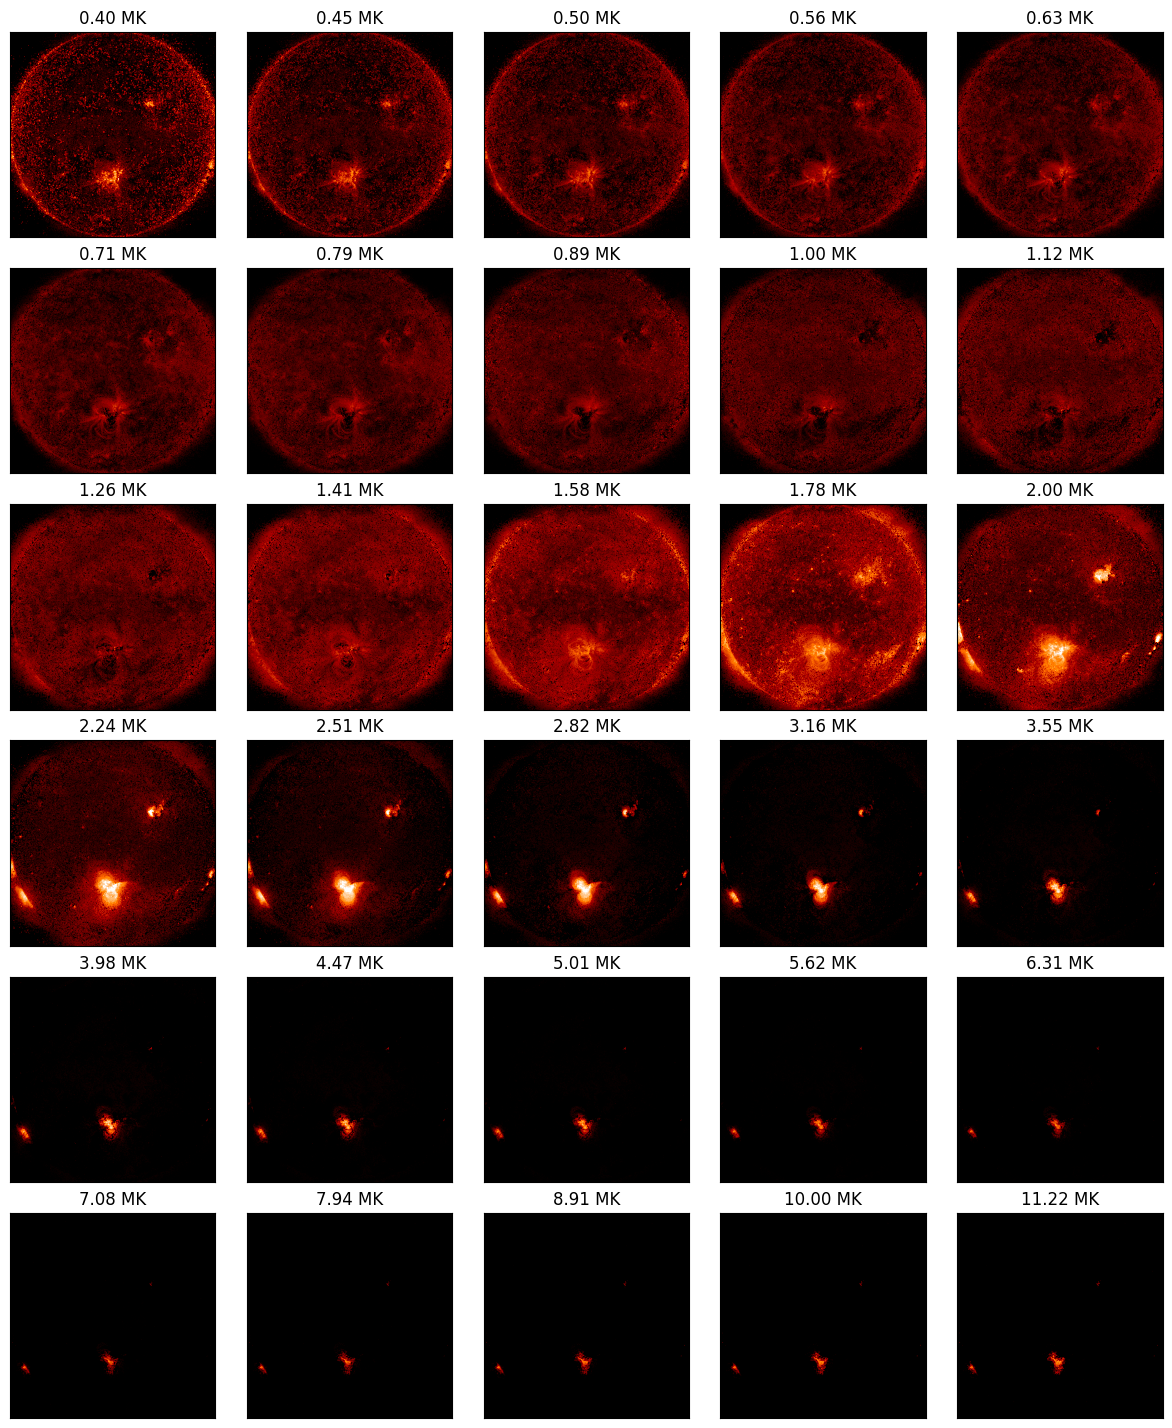

In [8]:
fig = plt.figure(figsize=(15,15*6/5))
norm = ImageNormalize(vmin=1e23,vmax=1e28, stretch=LogStretch())
tbin_centers = dem_cube.axis_world_coords(0)[0].to('MK')
for i in range(dem_cube.data.shape[0]):
    ax = fig.add_subplot(6,5,i+1,projection=dem_cube[i].wcs)
    dem_cube[i].plot(axes=ax, norm=norm, cmap='hinodexrt')
    lon,lat = ax.coords
    lon.set_ticklabel_visible(False)
    lat.set_ticklabel_visible(False)
    lon.set_ticks_visible(False)
    lat.set_ticks_visible(False)
    ax.set_title(f'{tbin_centers[i]:.2f}')
plt.subplots_adjust(hspace=0.15,wspace=0.1)

## 2. Read in CHIANTI Spectra

In [9]:
spectral_table = read_spectral_table('spectral-table.asdf')

Text(0.5, 1.0, 'Feldman CHIANTI Spectra')

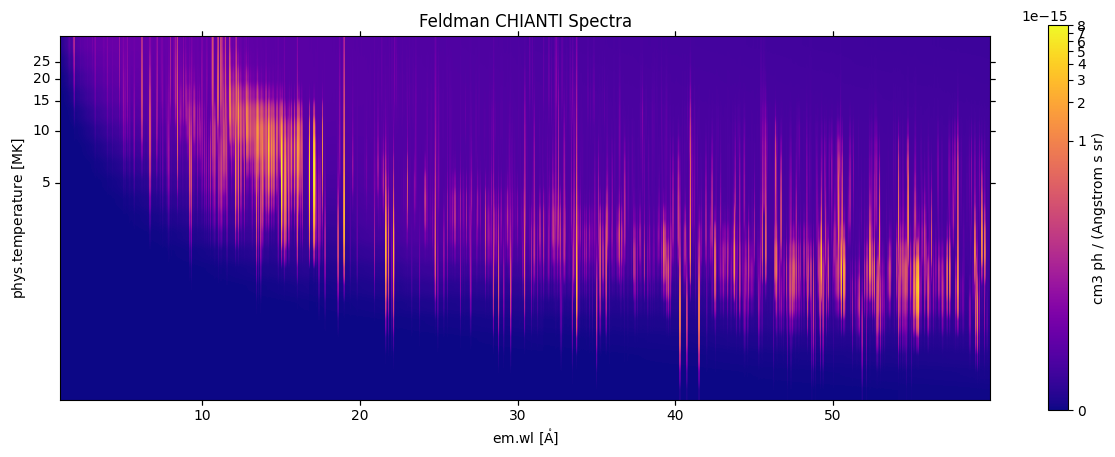

In [10]:
fig = plt.figure(figsize=(15,5))
spectral_table.plot(aspect=20,
                    axes_units=('MK','Angstrom'),
                    norm=ImageNormalize(stretch=LogStretch()),
                    cmap='plasma')
plt.colorbar(label=spectral_table.unit)
plt.title('Feldman CHIANTI Spectra')

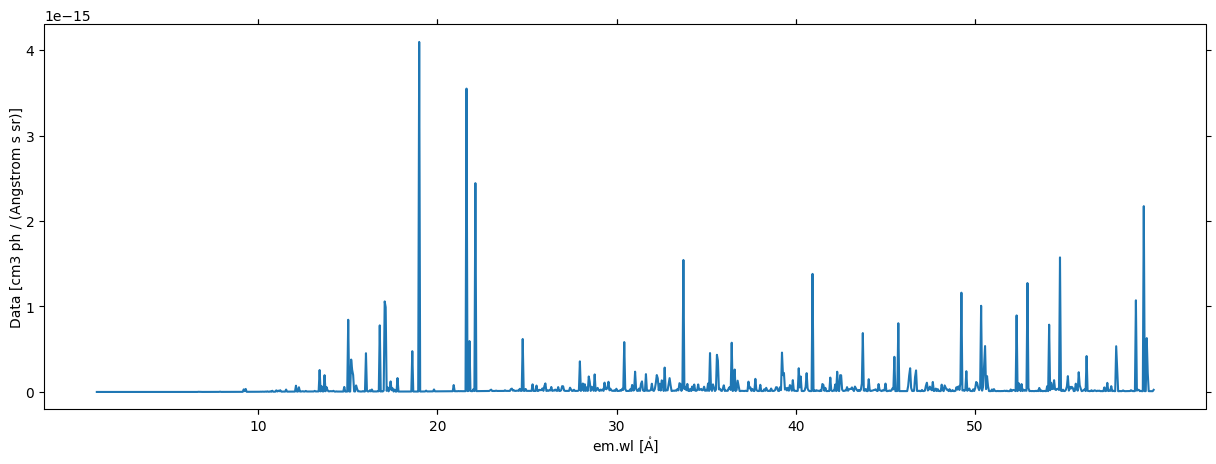

In [11]:
fig = plt.figure(figsize=(15,5))
i_T = np.argmin(np.fabs(spectral_table.axis_world_coords(0)[0] - 10**6.4*u.K))
ax = spectral_table[i_T,:].plot()

Let's zoom in on the brightest line near 18.9 Å

(318.1818213344431, 336.36364266888614)

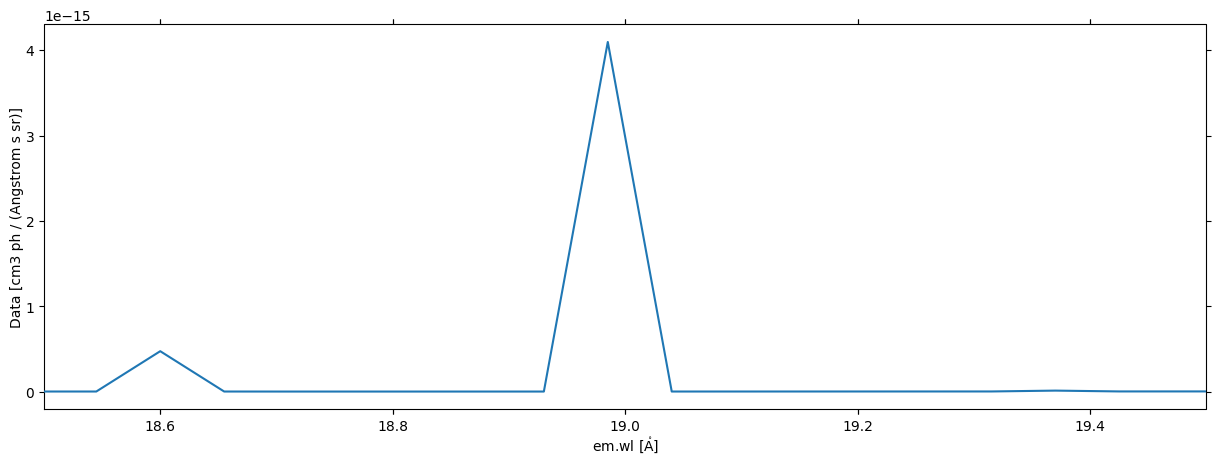

In [12]:
fig = plt.figure(figsize=(15,5))
i_T = np.argmin(np.fabs(spectral_table.axis_world_coords(0)[0] - 10**6.4*u.K))
ax = spectral_table[i_T,:].plot()
ax.set_xlim(spectral_table[i_T,:].wcs.world_to_pixel([18.5,19.5]*u.angstrom))

## 3. Integrate EM over temperature

Now, we compute the spectral cube by integrating each spectra over temperature, weighted by the emission measure distribution.

In [13]:
spec_cube = InstrumentDEM.calculate_intensity(
    dem_cube,
    spectral_table,
    dict(celestial_wcs.to_header())
)

Let's pick out the brightest pixel of the cube summed in wavelength and then plot the spectrum for that pixel.

In [14]:
ymax,xmax = np.unravel_index(np.argmax(spec_cube.data.sum(axis=0)),spec_cube.data.shape[1:])

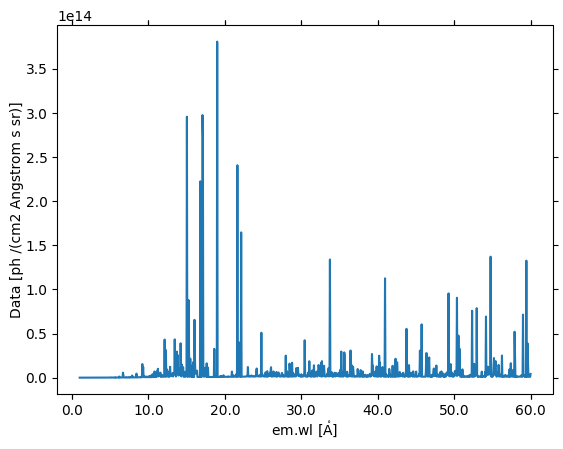

In [15]:
ax = spec_cube[:,ymax,xmax].plot(axes_units=['Angstrom'],
                                 data_unit='ph /(cm2 Angstrom s sr)')
ax.coords[0].set_major_formatter('x.x')
#plt.yscale('log')
#plt.ylim(1e10,1e15)

Let's plot the image corresponding to the brightest line in the above spectra. I've marked the corresponding coordinate of maximum intensity with a green x.

In [16]:
wave_index = np.argmax(spec_cube[:,ymax,xmax].data)
wave0 = spec_cube.axis_world_coords(0)[0][np.argmax(spec_cube[:,ymax,xmax].data)]
print(wave0.to('Angstrom'))

18.984982848167416 Angstrom


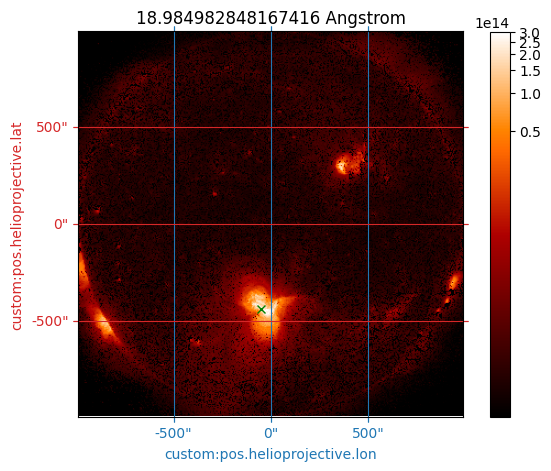

In [21]:
norm = ImageNormalize(vmin=1,vmax=3e14, stretch=LogStretch())
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection=spec_cube[wave_index])
spec_cube[wave_index].plot(
    axes=ax,
    cmap='hinodexrt',
    norm=norm,
    data_unit='ph / (cm2 Angstrom s sr)'
)
color_lat_lon_axes(ax)
ax.set_title(spec_cube.axis_world_coords(0)[0][wave_index].to('Angstrom'))
ax.plot(xmax,ymax,ls='',marker='x',color='g')
plt.colorbar()

## 4. Fold in instrument response

Next, fold this cube through the instrument response. This multiplies by the effective area, spatial plate scale, and spectral plate scale. We'll do this just for the 1st order case.

In [22]:
chan = SpectrogramChannel(1, '../../mocksipipeline/data/MOXSI_effarea.genx')

First, take a look at the effective area curve

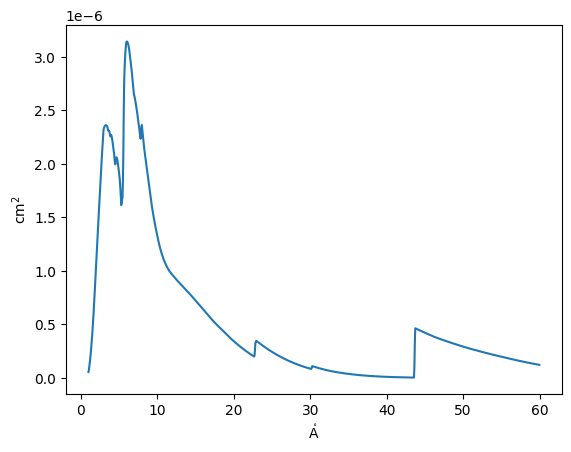

In [23]:
with quantity_support():
    plt.plot(chan.wavelength, chan.effective_area)

As well as the plate scale values

In [24]:
print(chan.plate_scale)

7.529785349783243e-10 sr / pix


In [25]:
print(chan.spectral_resolution)

0.055 Angstrom / pix


Let's convolve the spectral cube and the response

In [26]:
instr_cube = convolve_with_response(spec_cube, chan, include_gain=False)

And plot the two at the same wavelength as before

In [27]:
wave_index = np.argmin(np.fabs(wave0 - instr_cube.axis_world_coords(0)[0]))

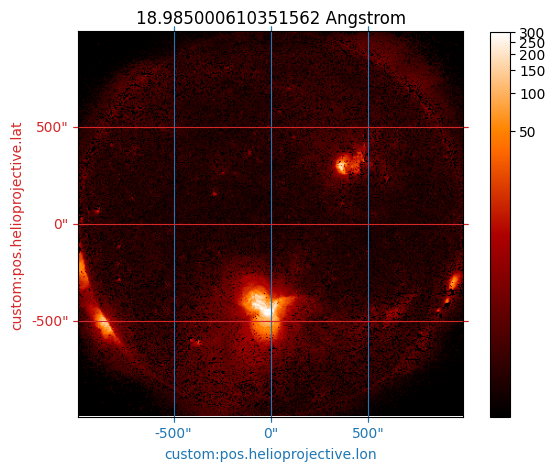

In [29]:
norm = ImageNormalize(vmin=0.01,vmax=300, stretch=LogStretch())
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection=instr_cube[wave_index])
instr_cube[wave_index].plot(
    axes=ax,
    cmap='hinodexrt',
    norm=norm,
    data_unit='ph / (Angstrom pix h)'
)
color_lat_lon_axes(ax)
ax.set_title(instr_cube.axis_world_coords(0)[0][wave_index].to('Angstrom'))
#ax.plot(xmax,ymax,ls='',marker='x',color='g')
plt.colorbar()

In [30]:
ymax,xmax = np.unravel_index(np.argmax(instr_cube.data.sum(axis=0)),
                             instr_cube.data.shape[1:])

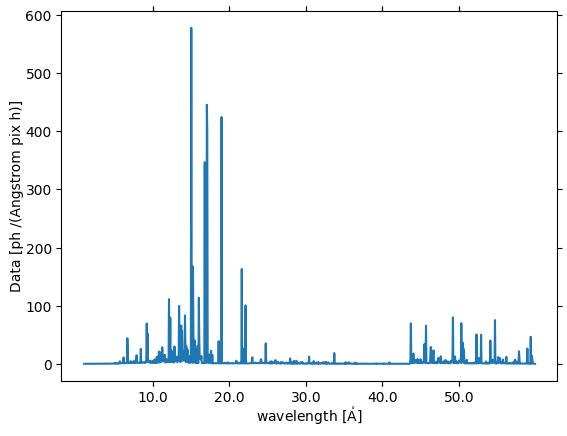

In [32]:
ax = instr_cube[:,ymax,xmax].plot(axes_units=['Angstrom'],
                                  data_unit='ph /(Angstrom pix h)')
ax.coords[0].set_major_formatter('x.x')
#plt.yscale('log')
#plt.ylim(1e10,1e15)

## 5. Reproject to Detector Plane

In [35]:
client = distributed.Client()

2022-09-16 12:56:06,665 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/dask-worker-space/worker-zh6drz_1', purging
2022-09-16 12:56:06,666 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/dask-worker-space/worker-1__egu2v', purging
2022-09-16 12:56:06,666 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/dask-worker-space/worker-ae3ezdc9', purging
2022-09-16 12:56:06,666 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/dask-worker-space/worker-wf841za5', purging
2022-09-16 12:56:06,667 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/dask-worker-space/worker-zivsrz0g', purging


In [38]:
overlap_o1 = reproject_to_overlappogram(
    instr_cube,
    chan.detector_shape,
    observer=observer,
    reference_pixel=(
        (chan.detector_shape[1] + 1)/2,
        (chan.detector_shape[0] + 1)/2,
        1,
    ) * u.pix,
    reference_coord=(
        0 * u.arcsec,
        0 * u.arcsec,
        chan.wavelength[0],
    ),
    scale=(
        chan.resolution[0],
        chan.resolution[1],
        chan.spectral_resolution,
    ),
    roll_angle=-90*u.deg,
    dispersion_angle=0*u.deg,
    dispersion_axis=0,
    order=chan.spectral_order,
    meta_keys=['CHANNAME'],
    use_dask=True,
    sum_over_lambda=True,
    algorithm='interpolation',
)

Now, analyze the resulting overlappogram

In [39]:
hpc_frame = astropy.wcs.utils.wcs_to_celestial_frame(overlap_o1.wcs)
blc = SkyCoord(Tx=-275*u.arcsec, Ty=-650*u.arcsec, frame=hpc_frame)
trc = SkyCoord(Tx=275*u.arcsec, Ty=5600*u.arcsec, frame=hpc_frame)
lower = SkyCoord(Tx=[trc.Tx,trc.Tx],Ty=[blc.Ty,trc.Ty],frame=hpc_frame)
upper = SkyCoord(Tx=[blc.Tx,blc.Tx],Ty=[blc.Ty,trc.Ty],frame=hpc_frame)

(<astropy.visualization.wcsaxes.coordinate_helpers.CoordinateHelper at 0x15270f970>,
 <astropy.visualization.wcsaxes.coordinate_helpers.CoordinateHelper at 0x1524cceb0>)

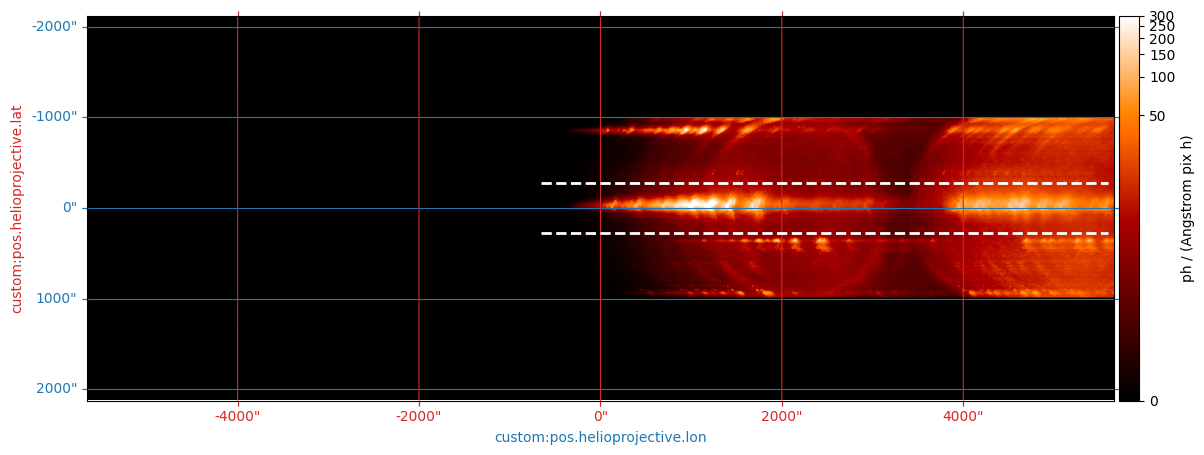

In [43]:
fig = plt.figure(figsize=(15,5))
wave_index = 0
norm = ImageNormalize(vmin=0,vmax=300,stretch=LogStretch())
ax = fig.add_subplot(111, projection=overlap_o1[wave_index].wcs)
plot_unit = 'ph / (Angstrom pix h)'
overlap_o1[wave_index].plot(
    axes=ax,
    cmap='hinodexrt',
    norm=norm,
    data_unit=plot_unit
)
ax.plot_coord(lower, ls='--', color='w', lw=2)
ax.plot_coord(upper, ls='--', color='w', lw=2)
im = ax.get_images()[0]
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.05, axes_class=matplotlib.axes.Axes)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cax.yaxis.set_ticks_position("right")
cbar.set_label(f'{plot_unit}',)
color_lat_lon_axes(ax)

In [44]:
overlap_o1_crop = overlap_o1[wave_index].crop(blc, trc)

(<astropy.visualization.wcsaxes.coordinate_helpers.CoordinateHelper at 0x151f7eeb0>,
 <astropy.visualization.wcsaxes.coordinate_helpers.CoordinateHelper at 0x151ddfa30>)

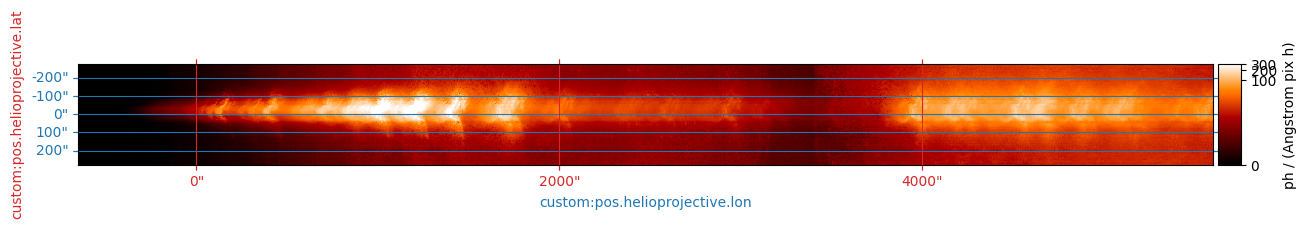

In [45]:
fig = plt.figure(figsize=(15,2.5))
ax = fig.add_subplot(111, projection=overlap_o1_crop.wcs)
overlap_o1_crop.plot(
    axes=ax,
    cmap='hinodexrt',
    norm=norm,
    data_unit=plot_unit
)
im = ax.get_images()[0]
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.05, axes_class=matplotlib.axes.Axes)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cax.yaxis.set_ticks_position("right")
cbar.set_label(f'{plot_unit}',)
color_lat_lon_axes(ax)

In [46]:
pix_x_cut = np.linspace(0, overlap_o1_crop.data.shape[1]-1, overlap_o1_crop.data.shape[1])
coord_cut = overlap_o1_crop.wcs.pixel_to_world(pix_x_cut, (overlap_o1_crop.data.shape[0]-1)/2)

(-648.0678674871172, 5599.194270288217)

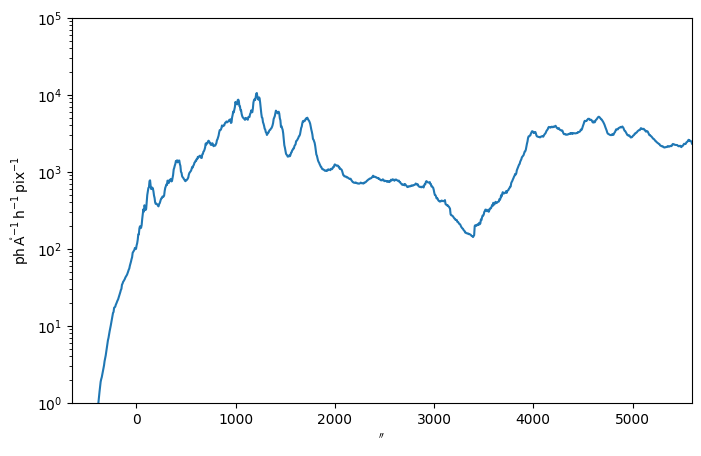

In [51]:
ar_sum = u.Quantity(overlap_o1_crop.data.sum(axis=0), overlap_o1_crop.unit)

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
with quantity_support():
    ax.plot(coord_cut.Ty, ar_sum.to(plot_unit),)
ax.set_yscale('log')
ax.set_ylim(1,1e5)
ax.set_xlim(coord_cut.Ty[[0,-1]].to_value('arcsec'))

## Sandbox

In [12]:
import specutils
from specutils.manipulation import FluxConservingResampler, LinearInterpolatedResampler

In [13]:
spectral_table

NDCube
------
Dimensions: [  21. 1073.] pix
Physical Types of Axes: [('phys.temperature', 'phys.density'), ('em.wl',)]
Unit: cm3 ph / (Angstrom s sr)
Data Type: float64

In [14]:
su_spec_cube = specutils.Spectrum1D(flux=spectral_table.data*spectral_table.unit, wcs=spectral_table[0,:].wcs)

In [15]:
su_spec_cube

<Spectrum1D(flux=<Quantity [[2.25204783e-211, 4.31376155e-201, 7.89238649e-192, ...,
            4.23137487e-019, 4.25571018e-019, 4.28017755e-019],
           [7.68563820e-171, 1.12038522e-162, 2.52956409e-155, ...,
            1.05246430e-018, 1.05688938e-018, 1.06146775e-018],
           [1.21703856e-138, 3.68088464e-132, 2.53135171e-126, ...,
            1.93597584e-018, 1.94111890e-018, 1.94851103e-018],
           ...,
           [2.74227206e-019, 3.81211277e-019, 5.11706501e-019, ...,
            7.63286147e-018, 7.62821787e-018, 7.62608485e-018],
           [9.59901649e-019, 1.23590792e-018, 1.54836156e-018, ...,
            7.31056620e-018, 7.30593205e-018, 7.30136578e-018],
           [2.57148386e-018, 3.11639307e-018, 3.69725574e-018, ...,
            6.97364966e-018, 6.96899607e-018, 6.96435276e-018]] cm3 ph / (Angstrom s sr)>, spectral_axis=<SpectralAxis [ 1.        ,  1.05499995,  1.11000001, ..., 59.84999847, 59.90499878,
   59.95999908] Angstrom>)>

In [41]:
new_spec_axis = np.arange(*su_spec_cube.spectral_axis[[0,-1]].to_value('Angstrom'),
                          0.01) * u.Angstrom

In [42]:
fcon_interp = FluxConservingResampler()

In [43]:
new_su_spec_cube = fcon_interp(su_spec_cube, new_spec_axis.to(su_spec_cube.spectral_axis.unit))

(15.0, 20.0)

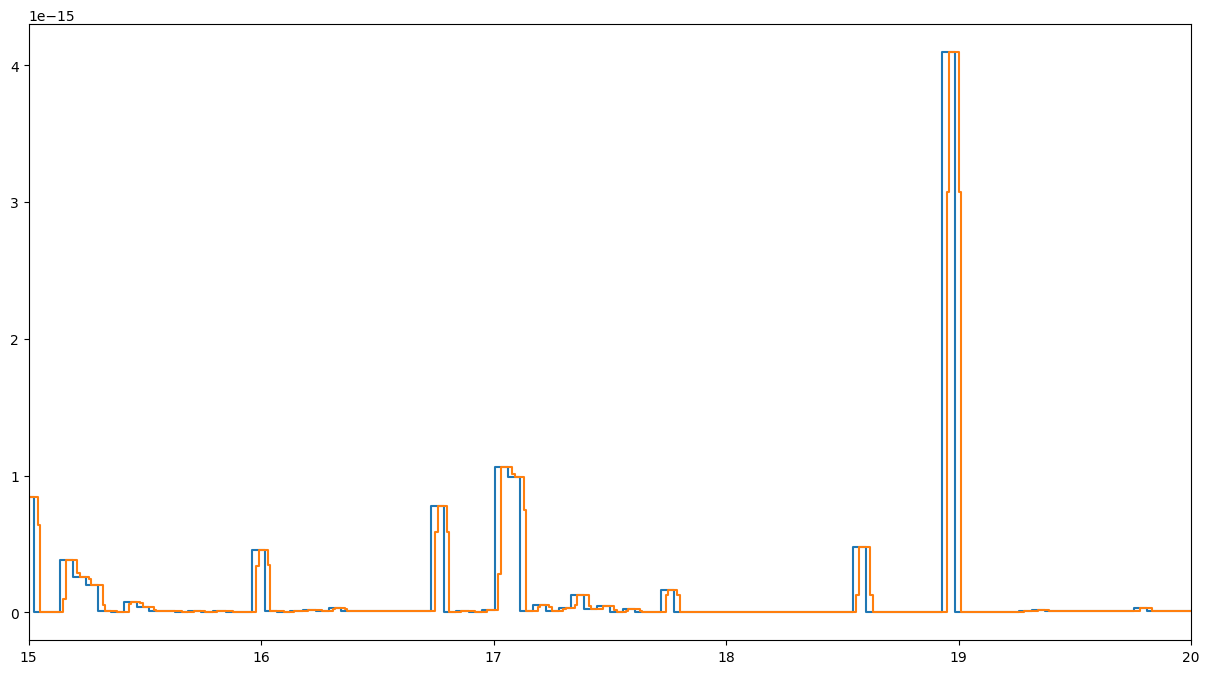

In [44]:
plt.figure(figsize=(15,8))
plt.step(su_spec_cube.spectral_axis, su_spec_cube.data[9,:])
plt.step(new_su_spec_cube.spectral_axis, new_su_spec_cube.data[9,:])
plt.xlim(15,20)
#plt.yscale('log')

In [69]:
su_spec_cube.spectral_axis_unit

        Use spectral_axis.unit instead. [warnings]


Unit("m")